<a href="https://colab.research.google.com/github/DeF0017/Deep-Face-Verification/blob/main/Face_Verification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Brief introduction

Face verification is a powerful technique that leverages deep learning to verify whether two face images belong to the same person.


Key Features:

Deep Convolutional Neural Network (CNN): model uses a deep CNN to extract features from face images.

Embedding Space: The model maps face images to a high-dimensional embedding space.

During training, model uses BCE loss to ensure that images of the same person are closer together in the embedding space than images of different people.

---



##Importing Dependencies

In [1]:
import uuid

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [39]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Layer, Input, Flatten
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

##Setup Paths

In [4]:
POS_PATH = os.path.join('Data','Positives')
NEG_PATH = os.path.join('Data', 'Negatives')
ANCHOR_PATH = os.path.join('Data', 'Anchor')

##Making the Directories

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANCHOR_PATH)

## Using LFW Dataset for Negative Images

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    old_path = os.path.join('lfw', directory, file)
    new_path = os.path.join(NEG_PATH, file)
    os.replace(old_path, new_path)

##Creating Data (Collecting Images for Positives and Anchor)

In [ ]:
vidcap = cv2.VideoCapture(0)
while vidcap.isOpened():
  ret, frame = vidcap.read()
  frame = frame[120:120+280,200:200+250,:]
  if cv2.waitKey(1) & 0XFF==ord('a'):
    imgname = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  if cv2.waitKey(1) & 0XFF==ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  cv2.imshow("Image Collection", frame)
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
vidcap.release()
cv2.destroyAllWindows()

## Scaling and Aligning Data

In [5]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def scale_Aug(file_path):
  img = cv2.imread(file_path)
  if img is None:
    print("Error: Image not found")
    return None

  # Step 3: Apply Haar Cascade to detect faces
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  # Check if no face is detected
  if len(faces) == 0:
    os.remove(file_path)
    print("No face detected")
    return None

  # Assume the first detected face is the one we want
  (x, y, w, h) = faces[0]

  # Step 4: Crop the face from the original colored image
  face_crop = img[y:y+h, x:x+w]

  # Optionally resize the face to a fixed size (e.g., 64x64)
  face_img = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
  face_resized = cv2.resize(face_img, (105, 105)).squeeze()
  cv2.imwrite(file_path, face_resized)

In [ ]:
for img_file in os.listdir(NEG_PATH):
  scale_Aug(os.path.join(NEG_PATH, img_file))

## Data Augmentation

In [6]:
def data_aug(img):
  data = []
  for i in range(9):
    img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
    img = tf.image.stateless_random_contrast(img, lower=0.5, upper=1, seed=(1,3))
    img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
    img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
    data.append(img)

  return data

In [ ]:
for file_path in os.listdir(os.path.join(POS_PATH)):
  img_path = os.path.join(POS_PATH, file_path)
  img = cv2.imread(img_path)
  aug_imgs = data_aug(img)

  for img in aug_imgs:
    cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), img.numpy())

In [ ]:
for file_path in os.listdir(ANCHOR_PATH):
  img = cv2.imread(os.path.join(ANCHOR_PATH, file_path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(os.path.join(ANCHOR_PATH, file_path), img)

## Creating Dataset with Anchor, Positives and Negatives

In [7]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpg').take(4000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(4000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(4000)

##Preprocessing and Scaling the Data

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (105, 105))
  img = img / 255.0
  return img

In [10]:
def preprocess_twin(input_img, val_img, label):
  return(preprocess(input_img), preprocess(val_img), label)

In [11]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [12]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
train_data = data.take(round(len(data)*0.8))
train_data = train_data.batch(64)
train_data = train_data.prefetch(32)

In [14]:
test_data = data.skip(round(len(data)*0.8))
test_data = test_data.take(round(len(data)*0.2))
test_data = test_data.batch(64)
test_data = test_data.prefetch(32)

## Embedding Layer using Deep CNN Architecture

In [15]:
def embedding_layer():
  inp = Input(shape=(105,105,1), name="input_layer")
  c1 = Conv2D(64, (10,10), activation="relu", name="conv1")(inp)
  mp1 = MaxPooling2D(64, (2,2), padding="same", name="maxpool1")(c1)
  c2 = Conv2D(128, (7,7), activation="relu", name="conv2")(mp1)
  mp2 = MaxPooling2D(64, (2,2), padding="same", name="maxpool2")(c2)
  c3 = Conv2D(128, (4,4), activation="relu", name="conv3")(mp2)
  mp3 = MaxPooling2D(64, (2,2), padding="same", name="maxpool3")(c3)
  c4 = Conv2D(256, (4,4), activation="relu", name="conv4")(mp3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation="sigmoid")(f1)

  return Model(inputs=[inp], outputs=d1, name="embedding")

In [16]:
model = embedding_layer()

In [17]:
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 105, 105, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 96, 96, 64)          │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2 (MaxPooling2D)              │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool3 (MaxPooling2D)              │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,947,648 (148.57 MB)

 Trainable params: 38,947,648 (148.57 MB)

 Non-trainable params: 0 (0.00 B)

## Distance Layer for calculating euclidean distance

In [18]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding-validation_embedding)

In [45]:
def faceVmodel():
  input_img = Input(name="Input_Image", shape=(105,105,1))
  val_img = Input(name="Validation_Image", shape=(105,105,1))

  siamese_layer = L1Dist()
  siamese_layer._name="Distance"
  dist = siamese_layer(model(input_img), model(val_img))

  result = Dense(1, activation="sigmoid", name="classifier")(dist)

  return Model(inputs=[input_img, val_img], outputs=result, name="Siamese_Model")

In [46]:
S_model = faceVmodel()

In [47]:
S_model.summary()

Model: "Siamese_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)      │ (None, 105, 105, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Validation_Image (InputLayer) │ (None, 105, 105, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,947,648 │ Input_Image[0][0],         │
│                               │                           │                 │ Validation_Image[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[6][0],           │
│                               │                           │                 │ embedding[7][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier (Dense)            │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [49]:
opt = tf.keras.optimizers.Adam(2e-4)

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt-2')
checkpoint = tf.train.Checkpoint(opt=opt, S_model=S_model)

## Train Step functions

In [51]:
@tf.function
def train_step(batch):
  loss=0
  # Record all of our operations
  with tf.GradientTape() as tape:
    # Get anchor and positive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]
    # Forward pass
    yhat = S_model(X, training=True)
    # Calculate loss
    loss += binary_cross_loss(y, yhat)
  # Calculate gradients
  grad = tape.gradient(loss, S_model.trainable_variables)

  # Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, S_model.trainable_variables))

  # Return loss
  return loss

In [52]:
def train(data, EPOCHS):
  # Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))
    # Creating a metric object
    r = Recall()
    p = Precision()
    loss = 0
    # Loop through each batch
    for idx, batch in enumerate(data):
      # Run train step here
      loss += train_step(batch)
      yhat = S_model.predict(batch[:2])
      r.update_state(batch[2], yhat)
      p.update_state(batch[2], yhat)
      progbar.update(idx+1)
    print(loss.numpy(),r.result().numpy(), p.result().numpy())

    # Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [53]:
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

# Restore the latest checkpoint
latest_checkpoint = checkpoint_prefix
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint restored from {}".format(latest_checkpoint))
else:
    print("No checkpoint found.")

Checkpoint restored from ./training_checkpoints\ckpt-2


In [ ]:
train(train_data, 10)


 Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 742ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
2/2 ━━━━━━━━

## Testing Model

In [54]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = S_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
0.99151516 0.998779


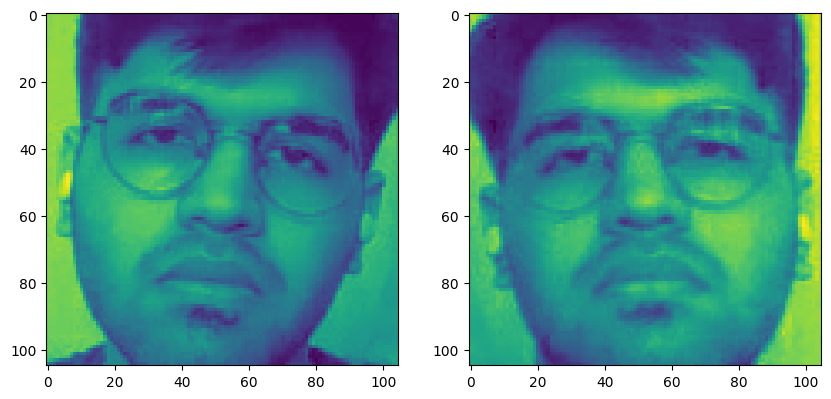

1.0


In [56]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()
print(y_true[2])

In [57]:
S_model.save('faceVmodel.h5')

## Verification Function

In [58]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    input_img = cv2.imread(os.path.join('application_data', 'input_image', 'input_image.jpg'), cv2.IMREAD_GRAYSCALE)

    faces = face_cascade.detectMultiScale(input_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces)>0:
       (x, y, w, h) = faces[0]
       face_crop = input_img[y:y+h, x:x+w]
       cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), face_crop)
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))

    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    print(verification)
    verified = verification > verification_threshold

    return results, verified

## Face Verification

1. Run the following cell
2. Webcam will open, Press 'v' on keyboard
3. If verified it will print True

   else it will print False

In [60]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+280,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(S_model, 0.5, 0.70)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━